In [8]:
# Pull in data and save it to a DataFrame

import pandas as pd

# Replace this with the path to your CSV file
file_path = '/Users/christopherfrye/Downloads/climate_risk.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the headers and the first 5 rows of the CSV
print("Headers:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Display summary statistics for each column
print(df.describe())


Headers: ['gvkey', 'capex_m_lag_w', 'roaq_lag_w', 'bk_leverage_lag_w', 'ppe_lag_w', 'logatq_lag_w', 'tobin_q_w', 'qtr', 'tran_risk_w_std', 'tran_risk_pro_w_std', 'tran_risk_npro_w_std', 'phy_risk_acute_w_std', 'phy_risk_chronic_w_std', 'ticker', 'company_name', 'industry_naics']

First few rows:
   gvkey  capex_m_lag_w  roaq_lag_w  bk_leverage_lag_w  ppe_lag_w  \
0   1004       0.775370    0.091727           0.285182   0.177044   
1   1004       2.169838    0.032214           0.101650   0.194719   
2   1004       0.990099    0.029251           0.116016   0.191637   
3   1045      12.023182    0.150515           0.409038   0.527381   
4   1045       3.219026    0.171135           0.404714   0.514223   

   logatq_lag_w  tobin_q_w  qtr  tran_risk_w_std  tran_risk_pro_w_std  \
0      7.708725   1.042455    1         0.000000                  0.0   
1      7.323171   0.934373    3         0.000000                  0.0   
2      7.344202   0.930979    4         0.000000                  0.0

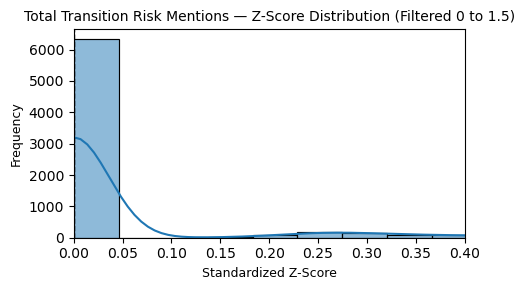

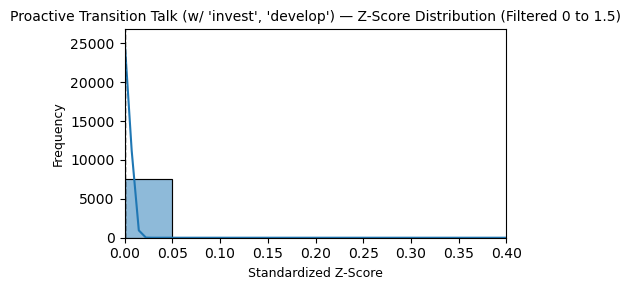

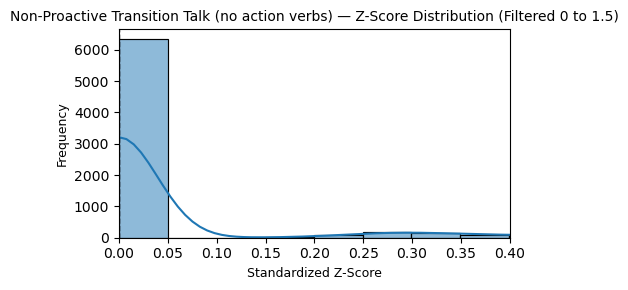

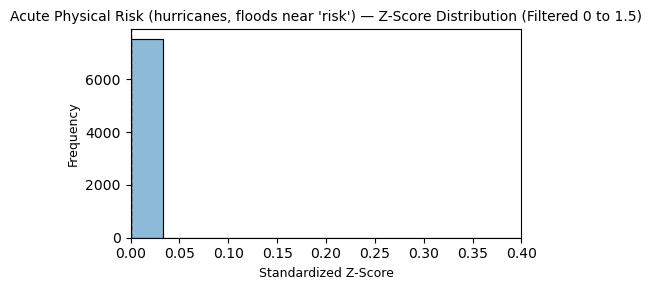

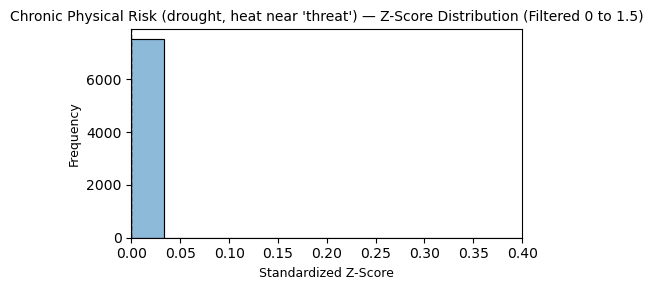

Top talkers: 533 unique companies
Silent companies: 2223 unique companies


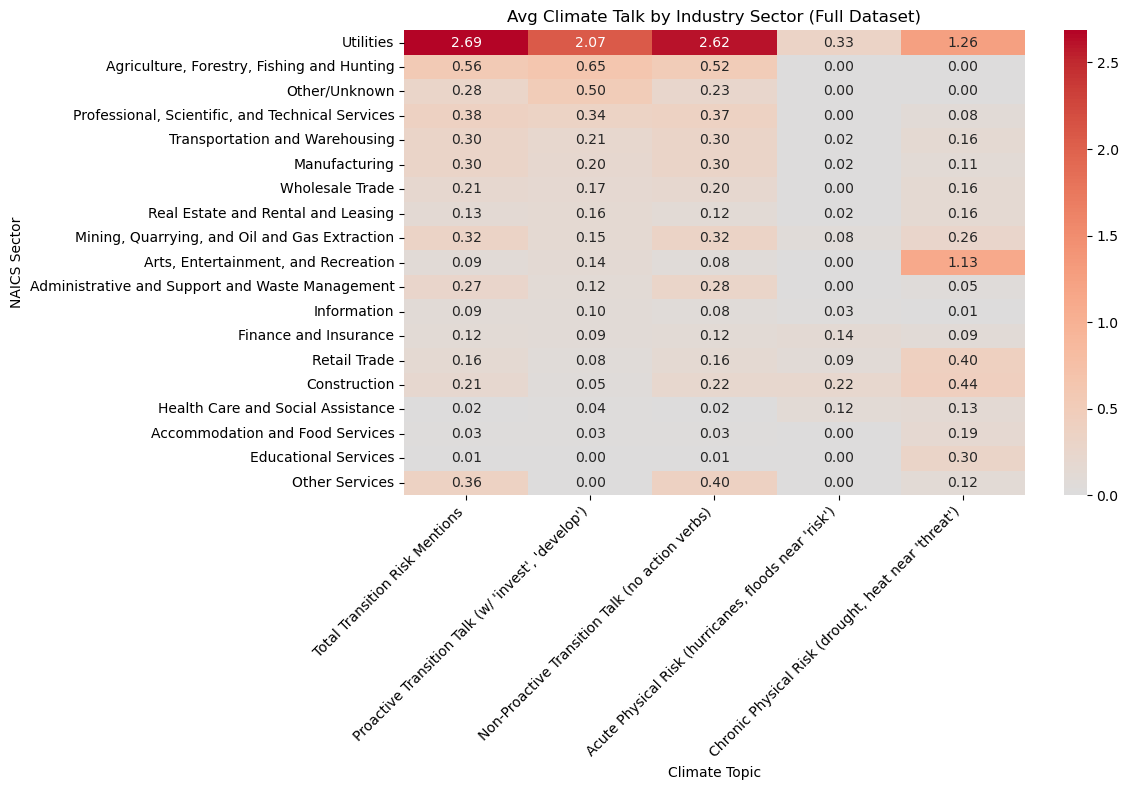

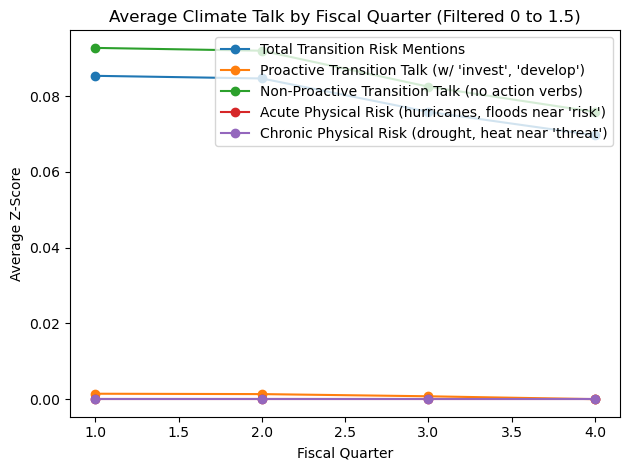

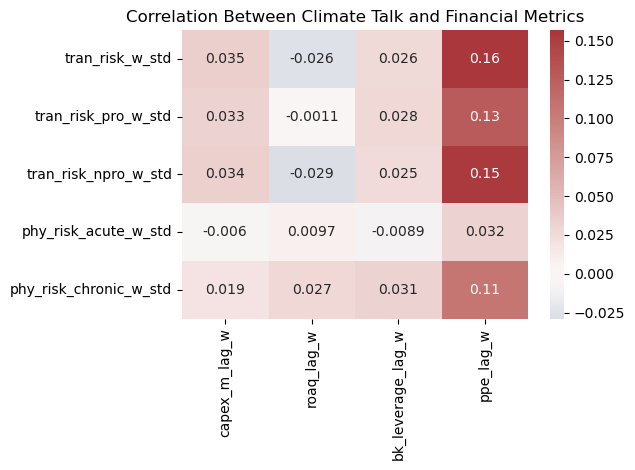

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define climate text variables
climate_cols = [
    'tran_risk_w_std', 'tran_risk_pro_w_std', 'tran_risk_npro_w_std',
    'phy_risk_acute_w_std', 'phy_risk_chronic_w_std'
]

# Filtered dataset: only z-scores between 0 and 1.5
df_filtered = df.copy()
for col in climate_cols:
    df_filtered = df_filtered[df_filtered[col].between(0, 1.5)]

# Descriptive labels for plotting
climate_labels = {
    'tran_risk_w_std': "Total Transition Risk Mentions",
    'tran_risk_pro_w_std': "Proactive Transition Talk (w/ 'invest', 'develop')",
    'tran_risk_npro_w_std': "Non-Proactive Transition Talk (no action verbs)",
    'phy_risk_acute_w_std': "Acute Physical Risk (hurricanes, floods near 'risk')",
    'phy_risk_chronic_w_std': "Chronic Physical Risk (drought, heat near 'threat')"
}

# Map NAICS industry codes to sector names
def map_naics_code(code):
    if 31 <= code <= 33:
        return "Manufacturing"
    elif 44 <= code <= 45:
        return "Retail Trade"
    elif 48 <= code <= 49:
        return "Transportation and Warehousing"
    return {
        11: "Agriculture, Forestry, Fishing and Hunting",
        21: "Mining, Quarrying, and Oil and Gas Extraction",
        22: "Utilities",
        23: "Construction",
        42: "Wholesale Trade",
        51: "Information",
        52: "Finance and Insurance",
        53: "Real Estate and Rental and Leasing",
        54: "Professional, Scientific, and Technical Services",
        55: "Management of Companies and Enterprises",
        56: "Administrative and Support and Waste Management",
        61: "Educational Services",
        62: "Health Care and Social Assistance",
        71: "Arts, Entertainment, and Recreation",
        72: "Accommodation and Food Services",
        81: "Other Services",
        92: "Public Administration"
    }.get(code, "Other/Unknown")

df['naics_sector'] = df['industry_naics'].astype(int).apply(map_naics_code)
df_filtered['naics_sector'] = df_filtered['industry_naics'].astype(int).apply(map_naics_code)

# HISTOGRAMS (Filtered 0 to 1.5)
for col in climate_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(df_filtered[col], kde=True, bins=30)
    plt.title(f"{climate_labels[col]} — Z-Score Distribution (Filtered 0 to 1.5)", fontsize=10)
    plt.xlabel("Standardized Z-Score", fontsize=9)
    plt.ylabel("Frequency", fontsize=9)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim(0, 0.4)  # tighter zoom for skewed data
    plt.tight_layout()
    plt.show()

# TOP & BOTTOM TALKERS (on full df)
top_talkers = df[df[climate_cols].max(axis=1) > 1.5]
silent_companies = df[df[climate_cols].abs().max(axis=1) < 0.1]

print(f"Top talkers: {top_talkers['company_name'].nunique()} unique companies")
print(f"Silent companies: {silent_companies['company_name'].nunique()} unique companies")

# INDUSTRY HEATMAP (on full df)

# Sort climate columns for consistent order
climate_cols_ordered = list(climate_labels.keys())
climate_labels_ordered = [climate_labels[col] for col in climate_cols_ordered]

# Compute summary and reorder columns
industry_summary = df.groupby('naics_sector')[climate_cols_ordered].mean()
industry_summary = industry_summary.sort_values('tran_risk_pro_w_std', ascending=False)
industry_summary.columns = climate_labels_ordered  # Rename columns with readable labels

# Plot heatmap with descriptive x-axis labels
plt.figure(figsize=(12, 8))
sns.heatmap(industry_summary, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('Avg Climate Talk by Industry Sector (Full Dataset)')
plt.xlabel('Climate Topic')
plt.ylabel('NAICS Sector')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# CLIMATE TALK OVER TIME (on filtered df)
quarterly_trends = df_filtered.groupby('qtr')[climate_cols].mean().reset_index()

quarterly_trends.plot(x='qtr', kind='line', marker='o')
plt.title('Average Climate Talk by Fiscal Quarter (Filtered 0 to 1.5)')
plt.xlabel('Fiscal Quarter')
plt.ylabel('Average Z-Score')
plt.legend([climate_labels[col] for col in climate_cols], loc='upper right')
plt.tight_layout()
plt.show()

# CLIMATE TALK VS. FINANCIALS (on full df)
financial_cols = ['capex_m_lag_w', 'roaq_lag_w', 'bk_leverage_lag_w', 'ppe_lag_w']

corr = df[climate_cols + financial_cols].corr()
sns.heatmap(corr.loc[climate_cols, financial_cols], annot=True, cmap='vlag', center=0)
plt.title("Correlation Between Climate Talk and Financial Metrics")
plt.tight_layout()
plt.show()